## 0.0 Instalar pacotes

In [ ]:
!pip install category_encoders
!pip install catboost

## 1.0 Importando bibliotecas

In [ ]:
import math
import datetime
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import pandas            as pd
import seaborn           as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, ShuffleSplit
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, \
HistGradientBoostingClassifier,StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, make_scorer, accuracy_score, precision_score, recall_score, auc
import pickle
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.feature_selection import VarianceThreshold
import random
import gc
# Definindo a semente
random.seed(123)

## 2.0 Funções auxiliares

In [ ]:
# Métricas do modelo

def calculate_metrics(nm_modelo, model, X_train, y_train, X_test, y_test):
    # Fazendo predições
    y_train_prob = (model.predict_proba(X_train))[:,1]
    y_test_prob = (model.predict_proba(X_test))[:,1]

    y_train_pred = (model.predict(X_train))
    y_test_pred = (model.predict(X_test))

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, np.array(y_train_prob))

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = np.array(y_train_prob)
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, np.array(y_test_prob))

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = np.array(y_test_prob)
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [nm_modelo, nm_modelo],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })
    return metrics_df

# Metadados referente ao conjunto de dados
def pod_academy_generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata=metadata.sort_values(by='percent_nulos',ascending=False)
    metadata = metadata.reset_index(drop=True)

    return metadata

## 3.0 Leitura dos dados

In [ ]:
df_treino_full = pd.read_parquet('PoD Bank/Tabelas - Feature_Engineering/abt_train_fselect.parquet')

In [ ]:
df_treino_full.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,CODE_GENDER,FLAG_OWN_CAR,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,OCCUPATION_TYPE,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TARGET
0,0,360000.0,1530000.0,42075.0,0.003122,-18850.0,-449.0,-4597.0,-2379.0,8.0,...,M,Y,State servant,Higher education,Managers,16,0,None,None,0
1,0,225000.0,481855.5,49374.0,0.025164,-11996.0,-2907.0,-2562.0,-4623.0,6.0,...,M,Y,Working,Secondary / secondary special,High skill tech staff,11,0,None,None,0
2,0,90000.0,760500.0,22234.5,0.028663,-17781.0,-7042.0,-6650.0,-1291.0,NaN,...,F,N,State servant,Higher education,Managers,11,0,None,None,0
3,0,112500.0,277969.5,10606.5,0.009175,-20438.0,-2271.0,-10241.0,-3991.0,17.0,...,M,Y,Working,Secondary / secondary special,Laborers,16,0,None,block of flats,0
4,2,90000.0,463284.0,22662.0,0.015221,-12855.0,-436.0,-2936.0,-5242.0,16.0,...,F,Y,Working,Secondary / secondary special,None,10,0,None,None,0


In [ ]:
df_treino_full.shape

(150580, 130)

In [ ]:
df_treino_full['TARGET'] = df_treino_full['TARGET'].astype(int)


In [ ]:
import warnings
warnings.filterwarnings("ignore")

## 4.0 Split dos dados

In [ ]:
abt = df_treino_full.drop(columns=['TARGET'])
target = df_treino_full.TARGET

X_train, X_test, y_train, y_test = train_test_split(abt,target,test_size=0.3,random_state=0)

## 5.0 Preparação dos dados e seleção de variáveis


In [ ]:
from sklearn.impute import SimpleImputer

abt_treino = pd.concat((X_train,y_train),axis=1)
abt_test = pd.concat((X_test,y_test),axis=1)

imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

num_features_train = X_train.select_dtypes(exclude='object')
cat_features_train = X_train.select_dtypes(include='object')

num_features_test = X_test[num_features_train.columns]
cat_features_test = X_test[cat_features_train.columns]

lista_nums = num_features_train.columns
lista_cats = cat_features_train.columns

df1 = pd.DataFrame(imputer_num.fit_transform(num_features_train),columns=lista_nums)
df2 = pd.DataFrame(imputer_num.transform(num_features_test),columns=lista_nums)
df1.index = num_features_train.index
df2.index = num_features_test.index
num_features_train = df1.copy()
num_features_test = df2.copy()

df1 = pd.DataFrame(imputer_cat.fit_transform(cat_features_train),columns=lista_cats)
df2 = pd.DataFrame(imputer_cat.transform(cat_features_test),columns=lista_cats)
df1.index = cat_features_train.index
df2.index = cat_features_test.index
cat_features_train = df1.copy()
cat_features_test = df2.copy()

ce = TargetEncoder()

cat_features_train = ce.fit_transform(cat_features_train,y_train)
cat_features_test = ce.transform(cat_features_test,y_test)

new_abt_treino = pd.concat((num_features_train,cat_features_train),axis=1)
new_abt_teste = pd.concat((num_features_test,cat_features_test),axis=1)

threshold = 0.5

# Calculate the correlation matrix
corr_matrix = new_abt_treino.corr().abs()

# Select the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns to drop based on the threshold
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

# Drop the columns
new_abt_treino = new_abt_treino.drop(columns=to_drop)
new_abt_teste = new_abt_teste.drop(columns=to_drop)

# new_abt_treino = pd.concat((new_abt_treino,y_train),axis=1)
# new_abt_teste = pd.concat((new_abt_teste,y_test),axis=1)

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
import xgboost as xgb
import matplotlib.pyplot as plt

xgb_model = xgb.XGBClassifier(random_state=0)
# xgb_model.fit(new_abt_treino.drop(columns=['CODE_GENDER']), y_train)
xgb_model.fit(new_abt_treino, y_train)

# Obter a importância das features
feature_importance = xgb_model.feature_importances_

# df = pd.DataFrame({'Feature':new_abt_treino.drop(columns=['CODE_GENDER']).columns,'Importance':feature_importance})
df = pd.DataFrame({'Feature':new_abt_treino.columns,'Importance':feature_importance})

features_rl = df.sort_values(by='Importance',ascending=False)[:20].Feature.to_list()

X_train_03 = new_abt_treino[features_rl]
X_test_03 = new_abt_teste[features_rl]

new_abt_treino = pd.concat((X_train_03,y_train),axis=1)
new_abt_teste = pd.concat((X_test_03,y_test),axis=1)

## 6.0 Verificar linearidade com a Log da Odds

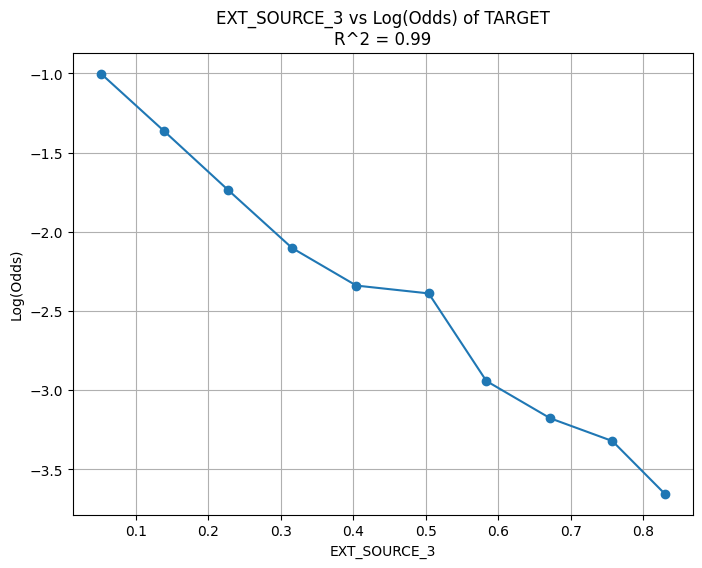

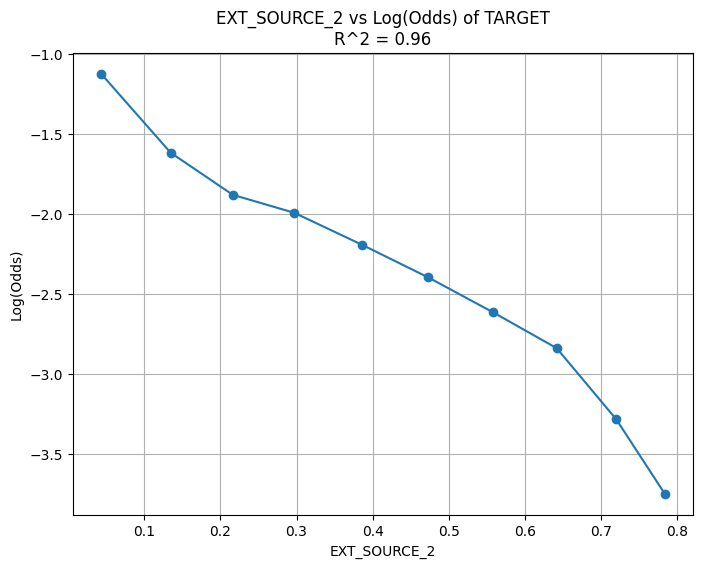

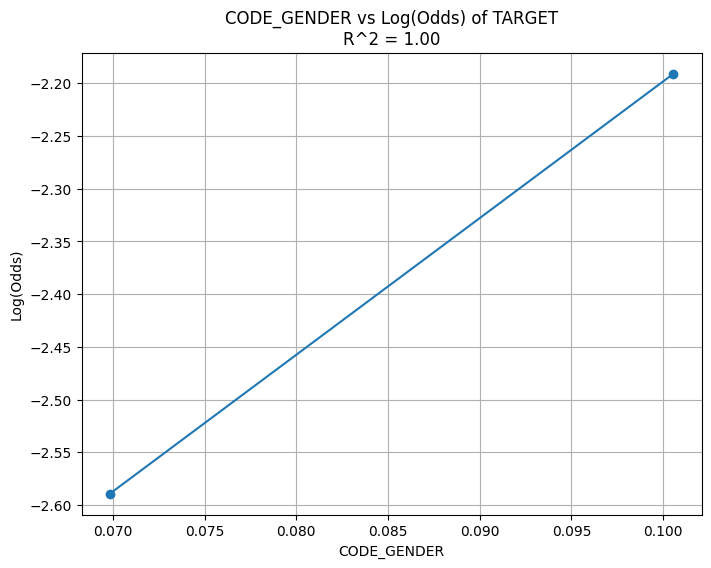

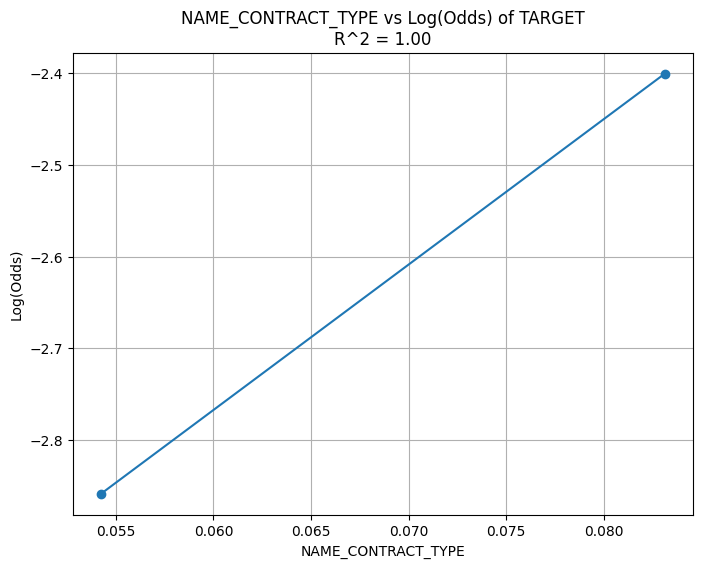

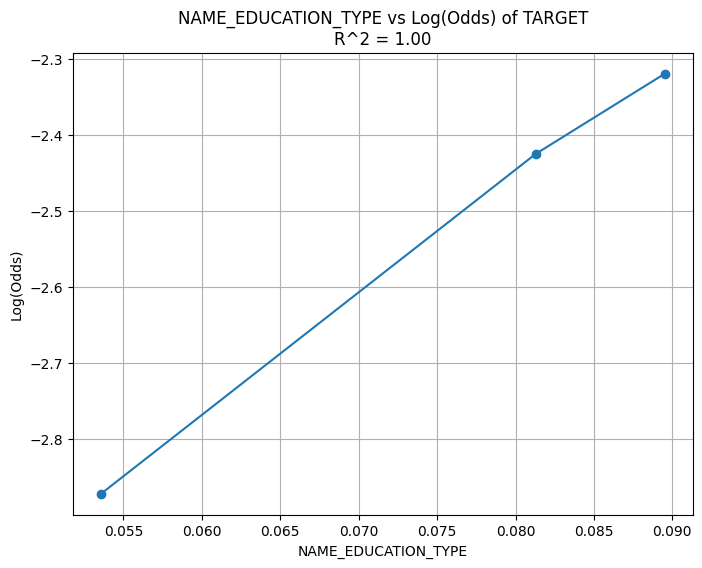

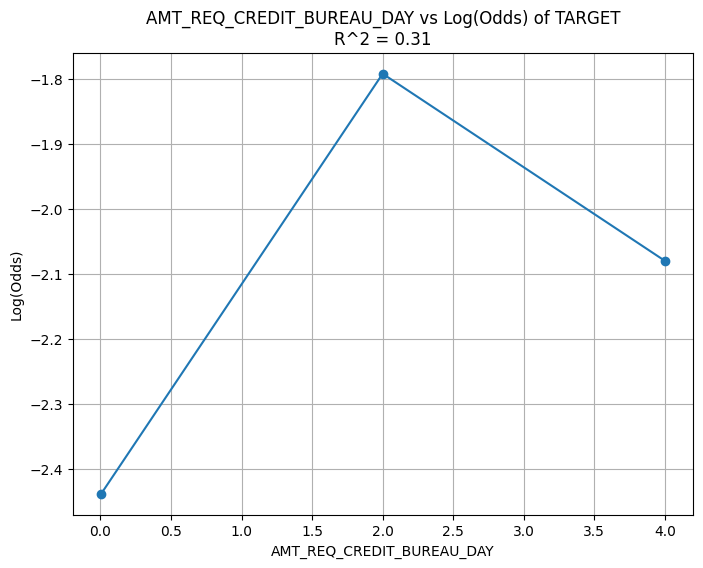

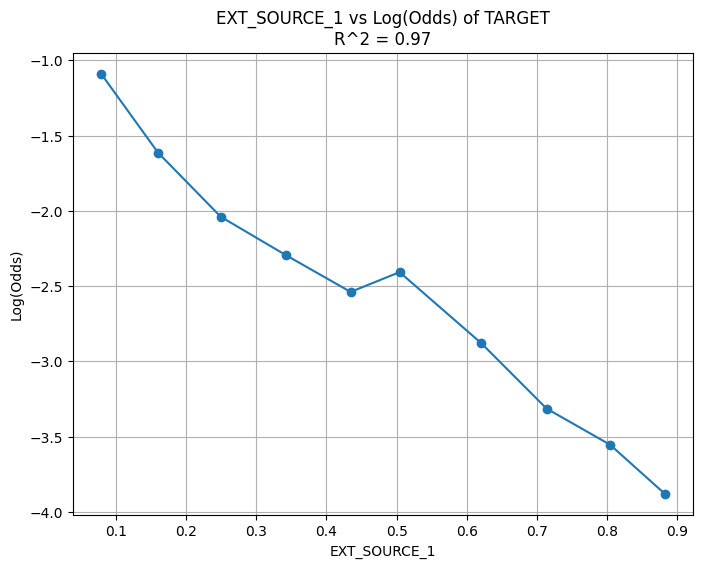

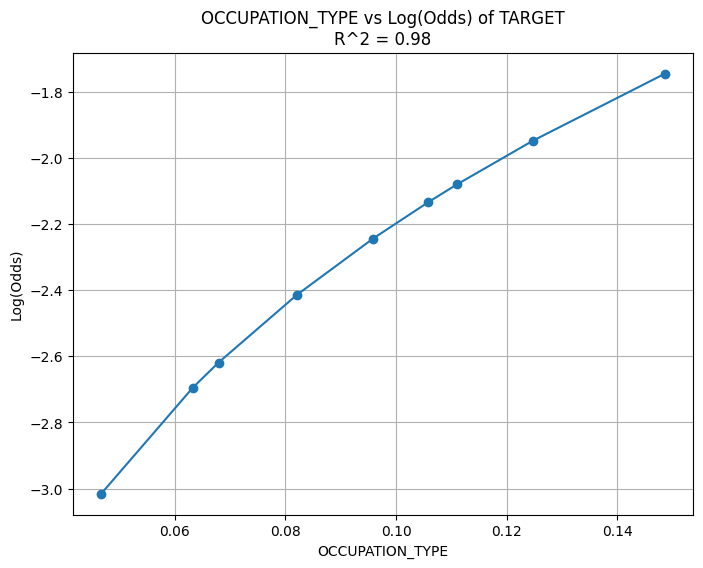

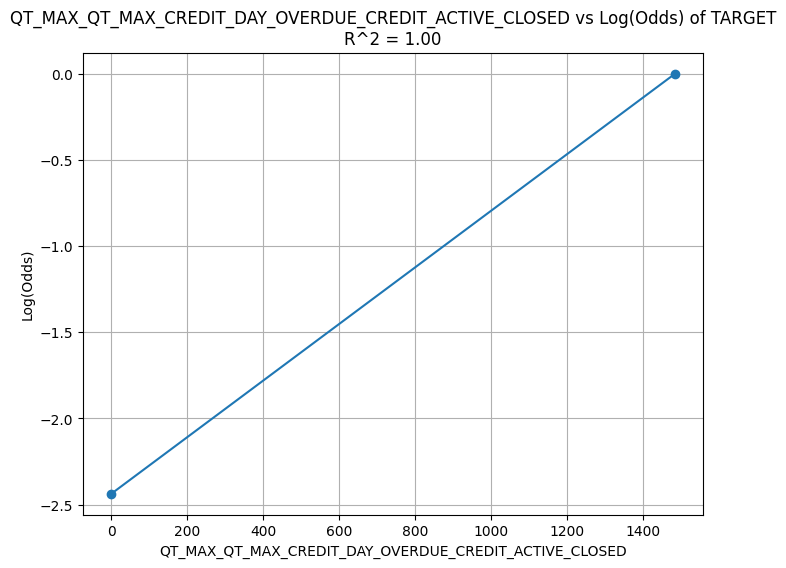

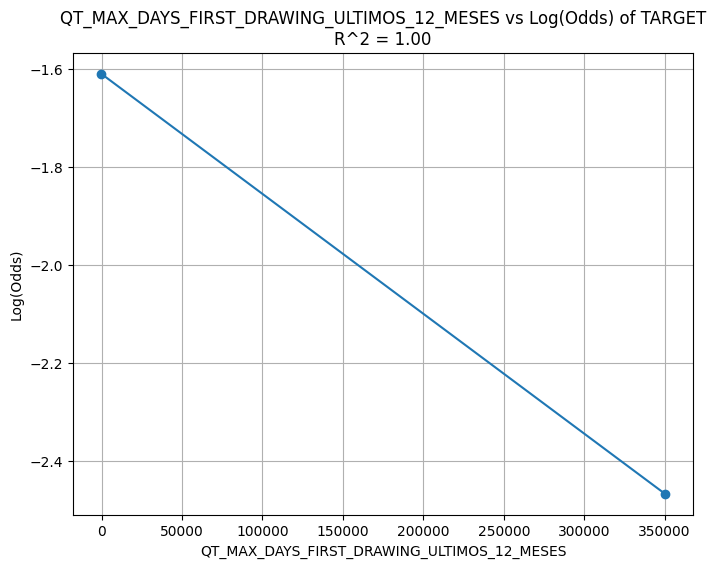

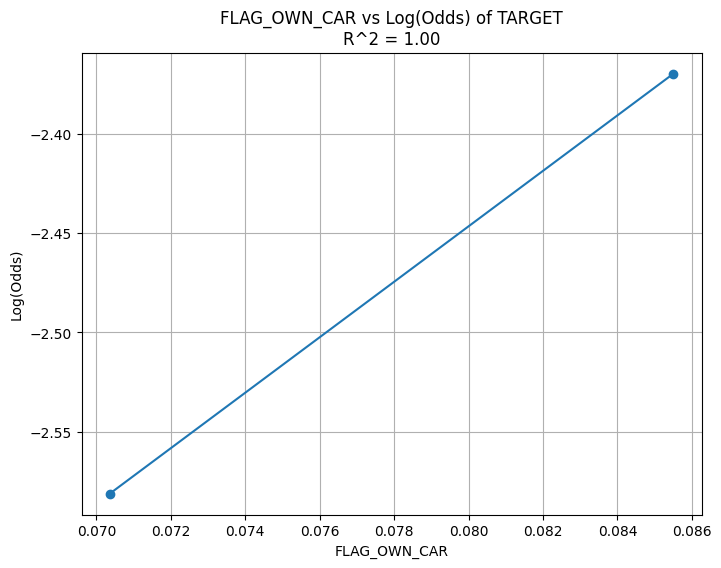

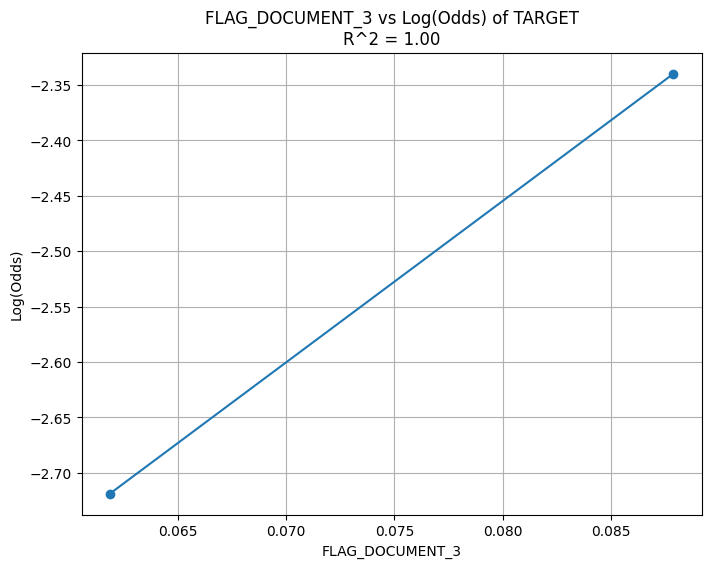

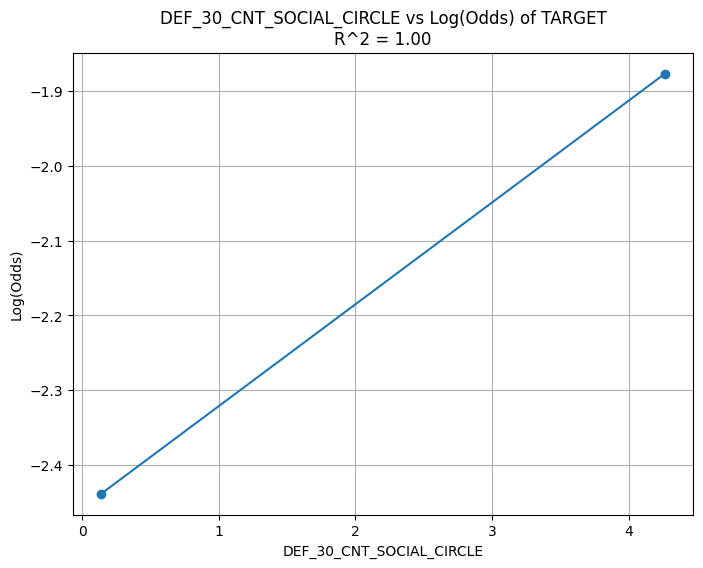

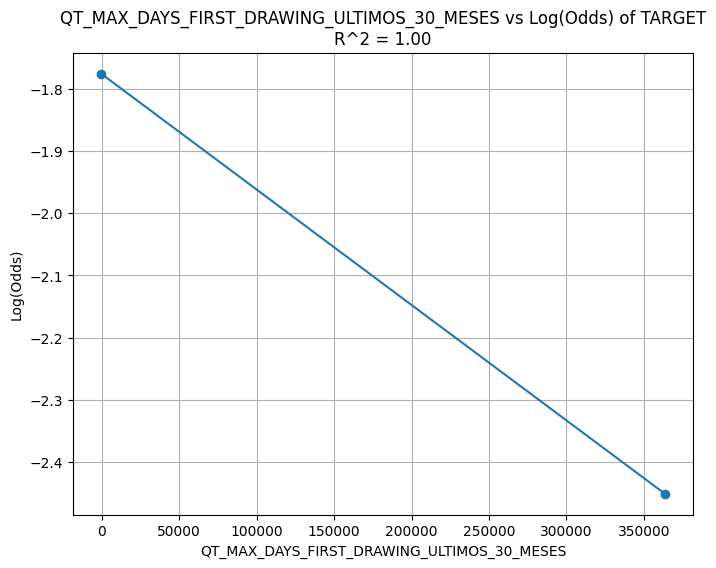

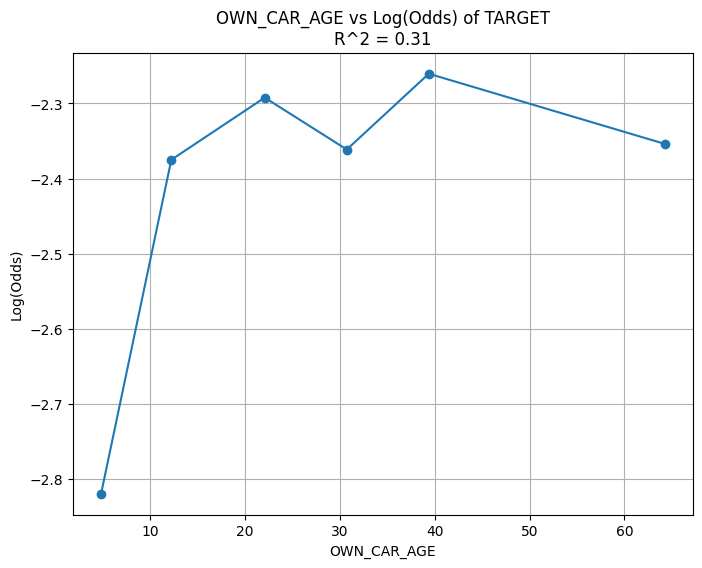

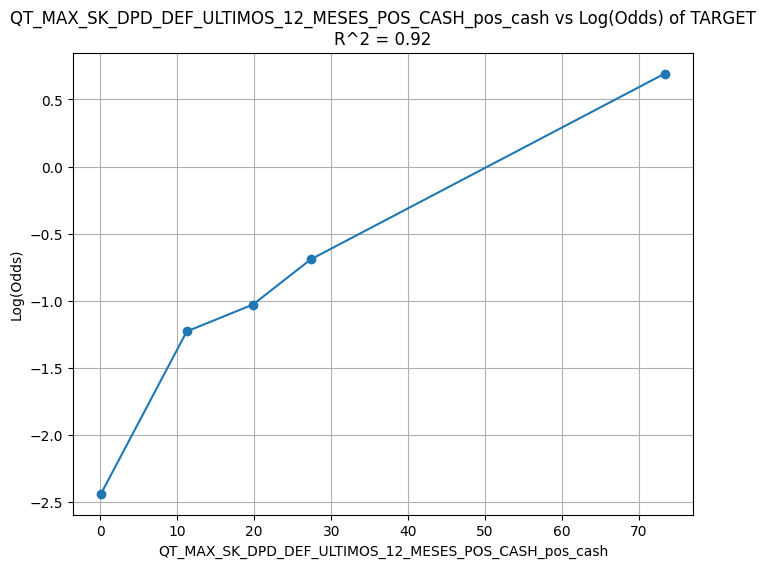

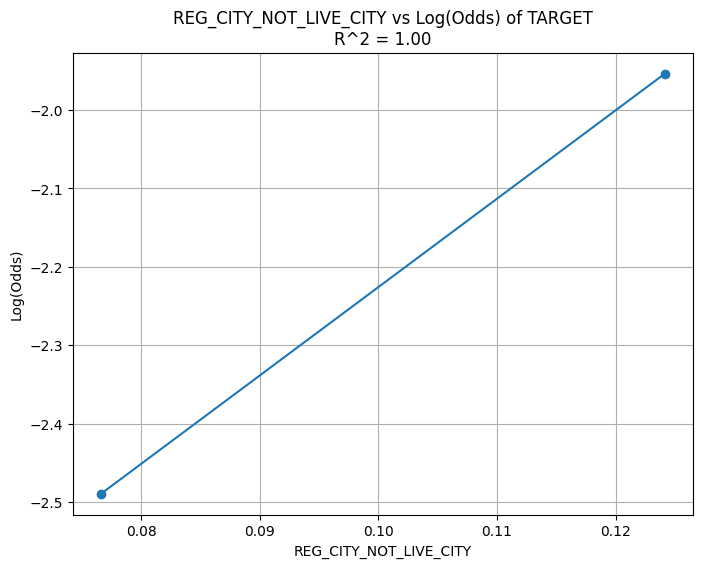

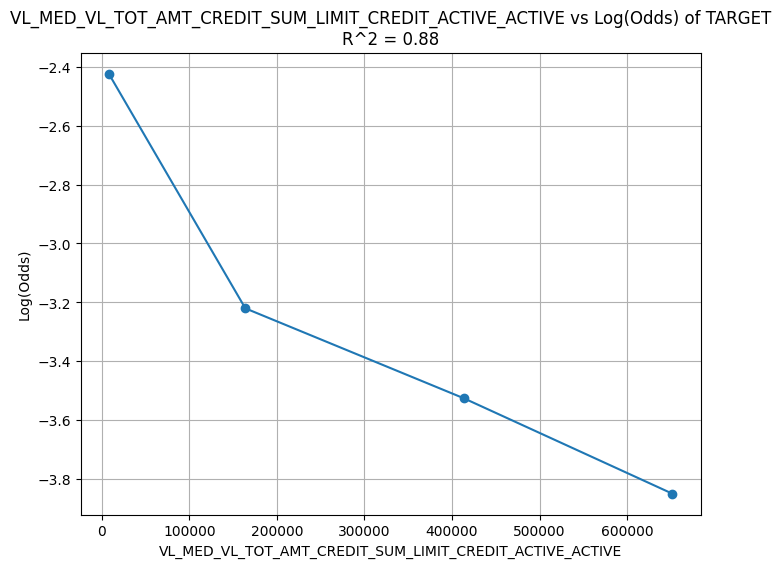

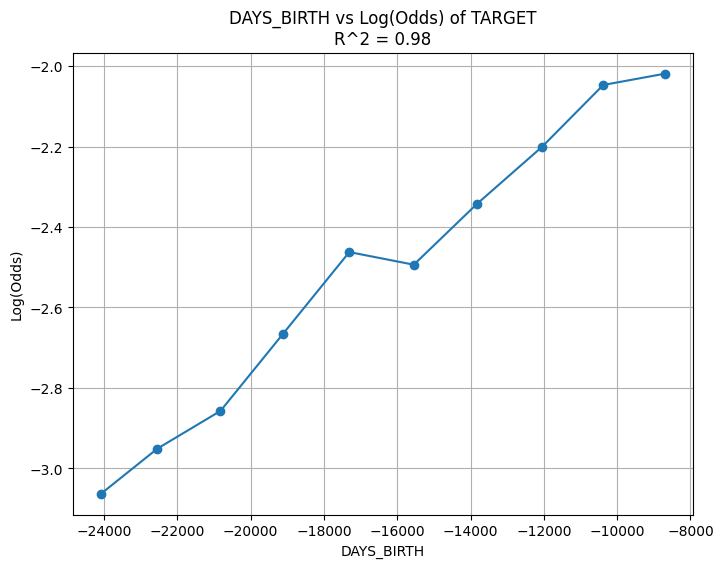

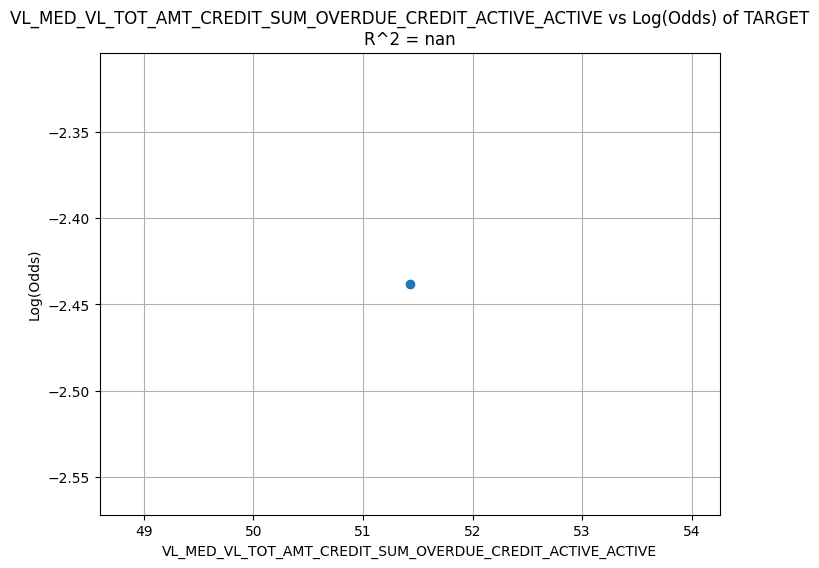

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def plot_variable_vs_logodds(df, variables, target):
    for variable in variables:
        # Verificando o número de valores únicos
        unique_vals = df[variable].nunique()
        if unique_vals == 1:
            print(f"{variable} tem apenas um valor único. Ignorando...")
            continue

        n_bins = min(10, unique_vals)

        # Criando bins para a variável
        df['bin'] = pd.cut(df[variable], bins=n_bins, labels=False, duplicates='drop')

        # Calculando a proporção de eventos positivos para cada bin
        mean_target = df.groupby('bin')[target].mean()

        # Calculando o log(odds) e tratando valores infinitos
        log_odds = np.log(mean_target / (1 - mean_target)).replace([np.inf, -np.inf], np.nan).dropna()

        # Calculando R^2
        X = df.groupby('bin')[variable].mean()[log_odds.index].values.reshape(-1, 1)
        y = log_odds.values
        model = LinearRegression().fit(X, y)
        r2 = model.score(X, y)

        # Plotando
        plt.figure(figsize=(8, 6))
        plt.plot(X, y, marker='o')
        plt.xlabel(variable)
        plt.ylabel('Log(Odds)')
        plt.title(f'{variable} vs Log(Odds) of {target}\nR^2 = {r2:.2f}')
        plt.grid(True)
        plt.show()

        # Removendo a coluna bin
        df.drop('bin', axis=1, inplace=True)

plot_variable_vs_logodds(new_abt_treino, list(new_abt_treino.drop(columns='TARGET').columns),'TARGET')

In [ ]:
def calculate_r2_for_logodds(df, variables, target, threshold):
    results = []

    for variable in variables:
        # Verificando o número de valores únicos
        unique_vals = df[variable].nunique()
        if unique_vals == 1:
            print(f"{variable} tem apenas um valor único. Ignorando...")
            continue

        n_bins = min(10, unique_vals)

        # Criando bins para a variável
        df['bin'] = pd.cut(df[variable], bins=n_bins, labels=False, duplicates='drop')

        # Calculando a proporção de eventos positivos para cada bin
        mean_target = df.groupby('bin')[target].mean()

        # Calculando o log(odds) e tratando valores infinitos
        log_odds = np.log(mean_target / (1 - mean_target)).replace([np.inf, -np.inf], np.nan).dropna()

        # Calculando R^2
        X = df.groupby('bin')[variable].mean()[log_odds.index].values.reshape(-1, 1)
        y = log_odds.values
        model = LinearRegression().fit(X, y)
        r2 = model.score(X, y)

        # Decidindo sobre a engenharia de recursos com base no valor de R^2 e no threshold fornecido
        feat_eng = "Usar como contínua" if r2 > threshold else "Categorizar"

        results.append({
            'Variable': variable,
            'R^2': r2,
            'Feat Eng': feat_eng
        })

        # Removendo a coluna bin
        df.drop('bin', axis=1, inplace=True)

    return pd.DataFrame(results)

r2_df = calculate_r2_for_logodds(new_abt_treino, list(new_abt_treino.drop(columns='TARGET').columns), 'TARGET',threshold=0.85)
r2_df

,Variable,R^2,Feat Eng
0,EXT_SOURCE_3,0.985815,Usar como contínua
1,EXT_SOURCE_2,0.962516,Usar como contínua
2,CODE_GENDER,1.000000,Usar como contínua
3,NAME_CONTRACT_TYPE,1.000000,Usar como contínua
4,NAME_EDUCATION_TYPE,0.998448,Usar como contínua
5,AMT_REQ_CREDIT_BUREAU_DAY,0.305617,Categorizar
6,EXT_SOURCE_1,0.970204,Usar como contínua
7,OCCUPATION_TYPE,0.975921,Usar como contínua
8,QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_CREDIT_ACTIVE...,1.000000,Usar como contínua
9,QT_MAX_DAYS_FIRST_DRAWING_ULTIMOS_12_MESES,1.000000,Usar como contínua


In [ ]:
variaveis_continuas = r2_df[r2_df['Feat Eng'] == 'Usar como contínua']['Variable'].tolist()
categorize_vars = r2_df[r2_df['Feat Eng'] == 'Categorizar']['Variable'].tolist()

## 7.1 Transformação matemática

### Avaliar se aplicar uma transformação matemática gera linearidade das demais variáveis com a log da odds

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def calculate_r2_for_logodds_and_transformations(df, variables, target, threshold):
    results = []

    transformations = {
        'AbsLog': lambda x: np.log(np.abs(x) + 1),  # Adicionamos 1 para evitar log(0)
        'Quadratic': lambda x: x**2
    }

    for variable in variables:
        best_transform_r2 = -np.inf
        best_transform_name = 'None'
        best_transform_function = None

        for transform_name, transform_function in transformations.items():
            transformed_var = transform_function(df[variable])

            # Verificando o número de valores únicos
            unique_vals = transformed_var.nunique()
            if unique_vals == 1:
                continue

            n_bins = min(10, unique_vals)

            # Criando bins para a variável transformada
            df['bin'] = pd.cut(transformed_var, bins=n_bins, labels=False, duplicates='drop')

            # Calculando a proporção de eventos positivos para cada bin
            mean_target = df.groupby('bin')[target].mean()

            # Calculando o log(odds) e tratando valores infinitos
            log_odds = np.log(mean_target / (1 - mean_target)).replace([np.inf, -np.inf], np.nan).dropna()

            # Calculando R^2
            X = df.groupby('bin')[transformed_var.name].mean()[log_odds.index].values.reshape(-1, 1)
            y = log_odds.values
            model = LinearRegression().fit(X, y)
            r2 = model.score(X, y)

            # Se essa transformação for a melhor até agora, atualize as melhores variáveis
            if r2 > best_transform_r2:
                best_transform_r2 = r2
                best_transform_name = transform_name
                best_transform_function = transform_function

            # Removendo a coluna bin
            df.drop('bin', axis=1, inplace=True)

        feat_eng = "Usar como contínua" if best_transform_r2 > threshold else "Categorizar"

        results.append({
            'Variable': variable,
            'Best Transformation': best_transform_name,
            'R^2 of Transformation': best_transform_r2,
            'Feat Eng': feat_eng,
            'Transformation Equation': f'{best_transform_name}({variable})'
        })

    return pd.DataFrame(results)

results_df = calculate_r2_for_logodds_and_transformations(new_abt_treino, categorize_vars, 'TARGET',threshold=0.85)
results_df

,Variable,Best Transformation,R^2 of Transformation,Feat Eng,Transformation Equation
0,AMT_REQ_CREDIT_BUREAU_DAY,Quadratic,1.000000,Usar como contínua,Quadratic(AMT_REQ_CREDIT_BUREAU_DAY)
1,OWN_CAR_AGE,AbsLog,0.342437,Categorizar,AbsLog(OWN_CAR_AGE)
2,VL_MED_VL_TOT_AMT_CREDIT_SUM_OVERDUE_CREDIT_AC...,AbsLog,0.212439,Categorizar,AbsLog(VL_MED_VL_TOT_AMT_CREDIT_SUM_OVERDUE_CR...


In [ ]:
def apply_best_transformations(results_df, original_df, drop_original=False):
    transformed_df = original_df.copy()

    transformations = {
        'AbsLog': lambda x: np.log(np.abs(x) + 1),
        'Quadratic': lambda x: x**2,
    }

    variables_transformed = []

    for index, row in results_df.iterrows():
        variable = row['Variable']
        best_transform_name = row['Best Transformation']
        feat_eng = row['Feat Eng']

        # Aplica a transformação conforme o resultado da análise
        if best_transform_name in transformations:
            transform_function = transformations[best_transform_name]
            transformed_var = transform_function(original_df[variable])
            transformed_df[f'TFE_{variable}'] = transformed_var
            variables_transformed.append(variable)

    # Descarta as variáveis originais se drop_original for True
    if drop_original:
        transformed_df.drop(variables_transformed, axis=1, inplace=True)

    return transformed_df

# Aplicar as transformações
new_abt_treino_transform = apply_best_transformations(results_df, new_abt_treino, drop_original=True)
new_abt_teste_transform = apply_best_transformations(results_df, new_abt_teste, drop_original=True)


In [ ]:
var = list(results_df[results_df['Feat Eng'] == 'Usar como contínua'].Variable)
var = ["TFE_" + variavel for variavel in var]
variaveis_continuas += var

## 7.2 Categorização

### Categorizar as variáveis que estão não apresentaram comportamento linear com a log da odds

In [ ]:
# Cálculo do R² considerando o dataset atualizado
r2_df = calculate_r2_for_logodds(new_abt_treino_transform, new_abt_treino_transform.drop(columns=['TARGET']), 'TARGET',threshold=0.85)

# Separar variáveis que ainda não se tornaram linear com o log da odds mesmo após as transformações
variaveis_categorizar = r2_df[r2_df['Feat Eng'] == 'Categorizar'].Variable.to_list()

# Verificar cardinalidade dessas variáveis
df = pod_academy_generate_metadata(new_abt_treino_transform[variaveis_categorizar])

In [ ]:
# Analizar essas variáveis (variaveis_categorizar) que contém baixa cardinalidade (menor ou igual a 20) e verificar se há ordenação entre as categorias
ordinais = df[df.cardinalidade <= 20].nome_variavel.to_list()

def analyze_variable(dataframe, variable, target):

    # Se a variável for numérica, arredonda para 4 casas decimais
    if pd.api.types.is_numeric_dtype(dataframe[variable]):
        dataframe[variable] = dataframe[variable].round(4)
        dataframe[variable] = dataframe[variable].astype(str)

    # Calcula a taxa de evento e o volume para cada categoria da variável
    result = dataframe.groupby(variable).agg({target: 'mean', variable: 'count'}).rename(columns={variable: 'Volume'}).reset_index()
    result.columns = [variable, 'Taxa_de_Evento', 'Volume']

    # Ordena o resultado pela Taxa de Evento em ordem decrescente
    result = result.sort_values(by='Taxa_de_Evento', ascending=False)

    # Plota o gráfico
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Eixo Y esquerdo: Volume
    bars = ax1.bar(result[variable], result['Volume'], color='lightblue', label='Volume (Barras)')
    ax1.set_xlabel(variable)
    ax1.set_ylabel('Volume', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # Eixo Y direito: Taxa de Evento
    ax2 = ax1.twinx()
    lines = ax2.plot(result[variable], result['Taxa_de_Evento'] * 100, marker='o', linestyle='-', color='hotpink', label='Taxa de Evento (Linha)')
    ax2.set_ylabel('Taxa de Evento (%)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Combina as legendas de ambos os eixos, filtrando rótulos que começam com '_'
    plots = [item for item in bars + tuple(lines) if not item.get_label().startswith('_')]
    labels = [plot.get_label() for plot in plots]
    plt.legend(plots, labels, loc='upper left')

    plt.title(f'Volume e Taxa de Evento por {variable}')
    plt.xticks(rotation=45)  # Adicionado para melhor visualização dos labels no eixo X
    plt.tight_layout()
    plt.show()

    return result

for var in ordinais:
    result = analyze_variable(new_abt_treino_transform, var, "TARGET")

In [ ]:
def categorize_with_decision_tree(dataframe, n_categories, target, numeric_var):
    import numpy as np
    # Preparar os dados
    X = dataframe[[numeric_var]]
    y = dataframe[target]

    # Treinar uma árvore de decisão com profundidade máxima igual ao número de categorias desejadas
    tree = DecisionTreeClassifier(max_leaf_nodes=n_categories)
    tree.fit(X, y)

    # Predizer a categoria (folha) para cada entrada no DataFrame
    leaf_ids = tree.apply(X)

    # Criar um DataFrame temporário com as categorias (folhas), a variável numérica e o target
    temp_df = pd.DataFrame({numeric_var: dataframe[numeric_var], 'Leaf': leaf_ids, target: y})

    result = temp_df.groupby('Leaf').agg({target: 'mean', numeric_var: ['count', 'min', 'max']}).reset_index()
    result.columns = ['Leaf', 'Taxa_de_Evento', 'Volume', 'Lower_Bound', 'Upper_Bound']

    # Ajuste para garantir que os limites superior e inferior de bins adjacentes não se sobreponham
    result = result.sort_values(by='Lower_Bound')
    for i in range(1, len(result)):
        result.iloc[i, 3] = max(result.iloc[i, 3], result.iloc[i-1, 4])

    # Definir o limite inferior do primeiro bin como -inf e o limite superior do último bin como inf
    result.iloc[0, 3] = -np.inf
    result.iloc[-1, 4] = np.inf

    return result

def apply_tree_bins(data, transformation_df, numeric_var):

    result.Upper_Bound = result.Upper_Bound.astype('float')
    result.Lower_Bound = result.Lower_Bound.astype('float')

    import numpy as np
    df_copy = data.copy()

    # Obtenha os limites superiores e ordene-os
    upper_bounds = transformation_df['Upper_Bound'].sort_values().values

    # Use numpy.digitize para determinar a qual bin cada valor pertence
    df_copy[f"TFT_{numeric_var}"] = np.digitize(df_copy[numeric_var].astype(float), upper_bounds)
    df_copy.drop(axis=1,columns=[numeric_var],inplace=True)

    return df_copy

In [ ]:
print('------------------------------- INÍCIO DA CATEGORIZAÇÃO ----------------------------')
print(f'------------------------------- {len(variaveis_categorizar)} VARIÁVEIS ---------------------------------------')
n = 0
# for var in vars_ordinais:
for var in variaveis_categorizar:
    if n == 0:
        result = categorize_with_decision_tree(new_abt_treino_transform, n_categories=3, target='TARGET', numeric_var=var)
        df1_treino = apply_tree_bins(new_abt_treino_transform, result, numeric_var=var)
        df1_teste = apply_tree_bins(new_abt_teste_transform, result, numeric_var=var)
    elif n == 1:
        result = categorize_with_decision_tree(df1_treino, n_categories=3, target='TARGET', numeric_var=var)
        df1_treino = apply_tree_bins(df1_treino, result, numeric_var=var)
        df1_teste = apply_tree_bins(df1_teste, result, numeric_var=var)
    n += 1
    print(f'------------------------------- FIM DA {n}ª ITERAÇÃO ---------------------------------')

var = ["TFT_" + palavra for palavra in variaveis_categorizar]

------------------------------- INÍCIO DA CATEGORIZAÇÃO ----------------------------
------------------------------- 2 VARIÁVEIS ---------------------------------------
------------------------------- FIM DA 1ª ITERAÇÃO ---------------------------------
------------------------------- FIM DA 2ª ITERAÇÃO ---------------------------------


In [ ]:
# Ajuste no tipo de variável
lista_onehot = ["TFT_" + variavel for variavel in variaveis_categorizar]
for var in lista_onehot:
  df1_treino[var] = df1_treino[var].astype(float)
  df1_teste[var] = df1_teste[var].astype(float)

import pickle
from sklearn.preprocessing import OneHotEncoder

X = df1_treino.drop(axis=1,columns=['TARGET'])

print('Lista de vars para OneHot Encoding: ',lista_onehot)

# Instanciando o encoder
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore',dtype=np.int32)
# Aplicando o one-hot encoding
encoded_data = encoder.fit_transform(df1_treino[lista_onehot])
encoded_cols = encoder.get_feature_names_out(lista_onehot)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=df1_treino.index)

df_train_03 = pd.concat([df1_treino.drop(lista_onehot, axis=1), encoded_df], axis=1)

# Salva o encoder e a lista de colunas em um arquivo .pkl
data_to_serialize = {
    'encoder': encoder,
    'columns': lista_onehot
}

Lista de vars para OneHot Encoding:  ['TFT_TFE_OWN_CAR_AGE', 'TFT_TFE_VL_MED_VL_TOT_AMT_CREDIT_SUM_OVERDUE_CREDIT_ACTIVE_ACTIVE']


In [ ]:
# Suponha test_df como sua base de teste
encoded_data_test = encoder.transform(df1_teste[lista_onehot])
encoded_cols_test = encoder.get_feature_names_out(lista_onehot)
encoded_df_test = pd.DataFrame(encoded_data_test, columns=encoded_cols_test, index=df1_teste.index)

df1_teste = pd.concat([df1_teste.drop(lista_onehot, axis=1), encoded_df_test], axis=1)

X = df_train_03.drop(axis=1,columns=['TARGET'])

lista_features_rl = list(X.columns)

In [ ]:
import pandas as pd
import statsmodels.api as sm

def logistic_regression_with_scorecard(data, target_var, features):

    data = data[features+[target_var]].copy()

    # Adicionando uma constante ao dataset (intercepto)
    data = sm.add_constant(data)

    # Ajustando o modelo de regressão logística
    model = sm.Logit(data[target_var], data[features + ['const']]).fit()
    # model = sm.Logit(data[target_var], data[features]).fit()

    # Coletando p-valores e estatísticas de Wald
    summary = model.summary2().tables[1]
    summary['Wald'] = summary['z']**2
    scorecard = summary[['Coef.', 'P>|z|', 'Wald']]
    scorecard.columns = ['Beta Coefficient', 'P-Value', 'Wald Statistic']
    scorecard = scorecard.sort_values(by='Wald Statistic', ascending=False)

    return model, scorecard

# model, scorecard = logistic_regression_with_scorecard(new_abt_treino, 'TARGET', vars2)
# model, scorecard = logistic_regression_with_scorecard(df1_treino, 'TARGET', vars)
# model, scorecard = logistic_regression_with_scorecard(df_train_03, 'TARGET', lista_features_rl)
# model, scorecard = logistic_regression_with_scorecard(new_abt_treino_transform, 'TARGET', variaveis)
model, scorecard = logistic_regression_with_scorecard(df_train_03, 'TARGET', lista_features_rl)
scorecard

Optimization terminated successfully.
         Current function value: 0.250205
         Iterations 7


,Beta Coefficient,P-Value,Wald Statistic
EXT_SOURCE_3,-2.679774e+00,0.000000e+00,1647.390317
EXT_SOURCE_2,-2.233910e+00,0.000000e+00,1531.805377
EXT_SOURCE_1,-1.230936e+00,6.909415e-41,179.294591
const,-3.580872e+00,6.681679e-40,174.781665
CODE_GENDER,9.918268e+00,4.377141e-29,125.299201
NAME_EDUCATION_TYPE,8.840450e+00,1.071121e-22,96.138670
OCCUPATION_TYPE,5.636541e+00,4.340585e-22,93.368712
QT_MAX_DAYS_FIRST_DRAWING_ULTIMOS_12_MESES,-1.414069e-06,1.799242e-16,67.811204
TFT_TFE_VL_MED_VL_TOT_AMT_CREDIT_SUM_OVERDUE_CREDIT_ACTIVE_ACTIVE_2.0,1.806449e+00,4.103812e-14,57.118243
FLAG_OWN_CAR,1.430268e+01,1.398994e-11,45.670706


In [ ]:
lista = pd.DataFrame(scorecard[scorecard['P-Value'] <= 0.05].reset_index()).rename(columns={'index':'variable'}).variable.to_list()
try:
    lista.remove('const')
except:
    pass
lista = lista[:28]

abt_new = df_train_03[lista]
abt_new = pd.concat((abt_new,y_train),axis=1)
abt_test_new = df1_teste[lista]
abt_test_new = pd.concat((abt_test_new,y_test),axis=1)

model, scorecard = logistic_regression_with_scorecard(abt_new, 'TARGET', abt_new.drop(columns='TARGET').columns.to_list())
scorecard

Optimization terminated successfully.
         Current function value: 0.250205
         Iterations 7


,Beta Coefficient,P-Value,Wald Statistic
EXT_SOURCE_3,-2.679711e+00,0.000000e+00,1647.438433
EXT_SOURCE_2,-2.233968e+00,0.000000e+00,1531.997858
EXT_SOURCE_1,-1.230892e+00,6.925175e-41,179.290060
const,-3.580935e+00,6.655728e-40,174.789404
CODE_GENDER,9.918657e+00,4.353005e-29,125.310174
NAME_EDUCATION_TYPE,8.840779e+00,1.066737e-22,96.146789
OCCUPATION_TYPE,5.636339e+00,4.353539e-22,93.362814
QT_MAX_DAYS_FIRST_DRAWING_ULTIMOS_12_MESES,-1.414129e-06,1.794012e-16,67.816944
TFT_TFE_VL_MED_VL_TOT_AMT_CREDIT_SUM_OVERDUE_CREDIT_ACTIVE_ACTIVE_2.0,1.806518e+00,4.094506e-14,57.122708
FLAG_OWN_CAR,1.430234e+01,1.400169e-11,45.669061


In [ ]:
abt_train_t01 = abt_new.drop(columns='TARGET').copy()
abt_teste_t01 = abt_test_new.drop(columns='TARGET').copy()

abt_train_t01['const'] = 1.0
abt_teste_t01['const'] = 1.0

abt_train_t01['Score_1'] = model.predict(abt_train_t01).round(4)
abt_teste_t01['Score_1'] = model.predict(abt_teste_t01).round(4)

abt_train_t01['Score_0'] = 1 - abt_train_t01['Score_1']
abt_teste_t01['Score_0'] = 1 - abt_teste_t01['Score_1']

abt_train_t01 = pd.concat((abt_train_t01,y_train),axis=1)
abt_teste_t01 = pd.concat((abt_teste_t01,y_test),axis=1)

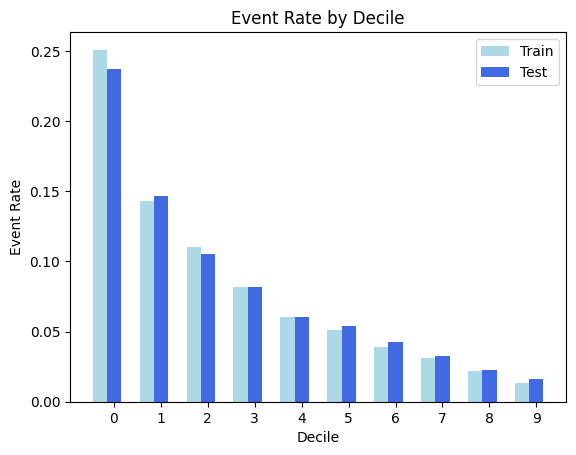

,Metric,Train Value,Test Value
0,KS,0.364325,0.343804
1,AUC,0.742500,0.731243
2,Gini,0.485000,0.462486


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import pandas as pd
import numpy as np

def calculate_metrics(train_df, test_df, score_column, score_0, target_column,bins=10):
    def compute_metrics(df, score_column, score_0, target_column):
        df_sorted = df.sort_values(by=score_column, ascending=False)

        # Calcular KS
        df_sorted['cum_good'] = (1 - df_sorted[target_column]).cumsum() / (1 - df_sorted[target_column]).sum()
        df_sorted['cum_bad'] = df_sorted[target_column].cumsum() / df_sorted[target_column].sum()
        df_sorted['ks'] = np.abs(df_sorted['cum_good'] - df_sorted['cum_bad'])
        ks_statistic = df_sorted['ks'].max()

        # Calcular AUC
        auc_value = roc_auc_score(df_sorted[target_column], df_sorted[score_column])

        # Calcular Gini
        gini = 2 * auc_value - 1

        # Dividir o score em 10 faixas
        df_sorted['decile'] = pd.qcut(df_sorted[score_0], bins, labels=False)

        # Criar tabela detalhada
        table = df_sorted.groupby('decile').agg(
            min_score=pd.NamedAgg(column=score_0, aggfunc='min'),
            max_score=pd.NamedAgg(column=score_0, aggfunc='max'),
            event_rate=pd.NamedAgg(column=target_column, aggfunc='mean'),
            volume=pd.NamedAgg(column=target_column, aggfunc='size')
        ).reset_index()

        return ks_statistic, auc_value, gini, table

    ks_train, auc_train, gini_train, table_train = compute_metrics(train_df, score_column, score_0, target_column)
    ks_test, auc_test, gini_test, table_test = compute_metrics(test_df, score_column, score_0, target_column)

    # Plotando o gráfico de barras para Event Rate por Decil
    barWidth = 0.3
    r1 = np.arange(len(table_train))
    r2 = [x + barWidth for x in r1]

    plt.bar(r1, table_train['event_rate'], color='lightblue', width=barWidth, label='Train')
    plt.bar(r2, table_test['event_rate'], color='royalblue', width=barWidth, label='Test')

    plt.xlabel('Decile')
    plt.ylabel('Event Rate')
    plt.title('Event Rate by Decile')
    plt.xticks([r + barWidth for r in range(len(table_train))], table_train['decile'])
    plt.legend()
    plt.show()

    # Criando DataFrame para as métricas
    metrics_df = pd.DataFrame({
        'Metric': ['KS', 'AUC', 'Gini'],
        'Train Value': [ks_train, auc_train, gini_train],
        'Test Value': [ks_test, auc_test, gini_test]
    })

    return metrics_df, table_train, table_test

metrics, ord_score_train, ord_score_test = calculate_metrics(abt_train_t01, abt_teste_t01, 'Score_1', 'Score_0', 'TARGET',bins=10)
metrics

In [ ]:
ord_score_train

,decile,min_score,max_score,event_rate,volume
0,0,0.0383,0.8306,0.250783,10543
1,1,0.8307,0.8834,0.142817,10566
2,2,0.8835,0.9116,0.110383,10527
3,3,0.9117,0.9302,0.081822,10584
4,4,0.9303,0.9436,0.060197,10532
5,5,0.9437,0.9542,0.051102,10528
6,6,0.9543,0.9631,0.038994,10540
7,7,0.9632,0.9712,0.031475,10548
8,8,0.9713,0.9794,0.022002,10590
9,9,0.9795,0.9999,0.013495,10448


In [ ]:
ord_score_test

,decile,min_score,max_score,event_rate,volume
0,0,0.0079,0.8340,0.237284,4522
1,1,0.8341,0.8850,0.146552,4524
2,2,0.8851,0.9128,0.105182,4535
3,3,0.9129,0.9308,0.081646,4495
4,4,0.9309,0.9444,0.060626,4536
5,5,0.9445,0.9549,0.054144,4525
6,6,0.9550,0.9636,0.042803,4509
7,7,0.9637,0.9713,0.032279,4523
8,8,0.9714,0.9794,0.022482,4537
9,9,0.9795,0.9999,0.016115,4468


In [ ]:
import pickle
with open('PoD Bank/Artefatos de Modelo/Regressão Logistica/modelo_regressao_logistica.pkl', 'wb') as file:
    pickle.dump(model, file)